In [1]:
# Module import

from __future__ import print_function

from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
#
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion_implementation import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u
import time
from scipy import sparse as sps
from astropy.coordinates import SkyCoord
import healpy as hp
import copy
from tqdm import trange

# Ipython magics
%load_ext autoreload
%autoreload 2
#%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# For scaling: 
Table resuming the scaling that has to be done. (not yet implemented)

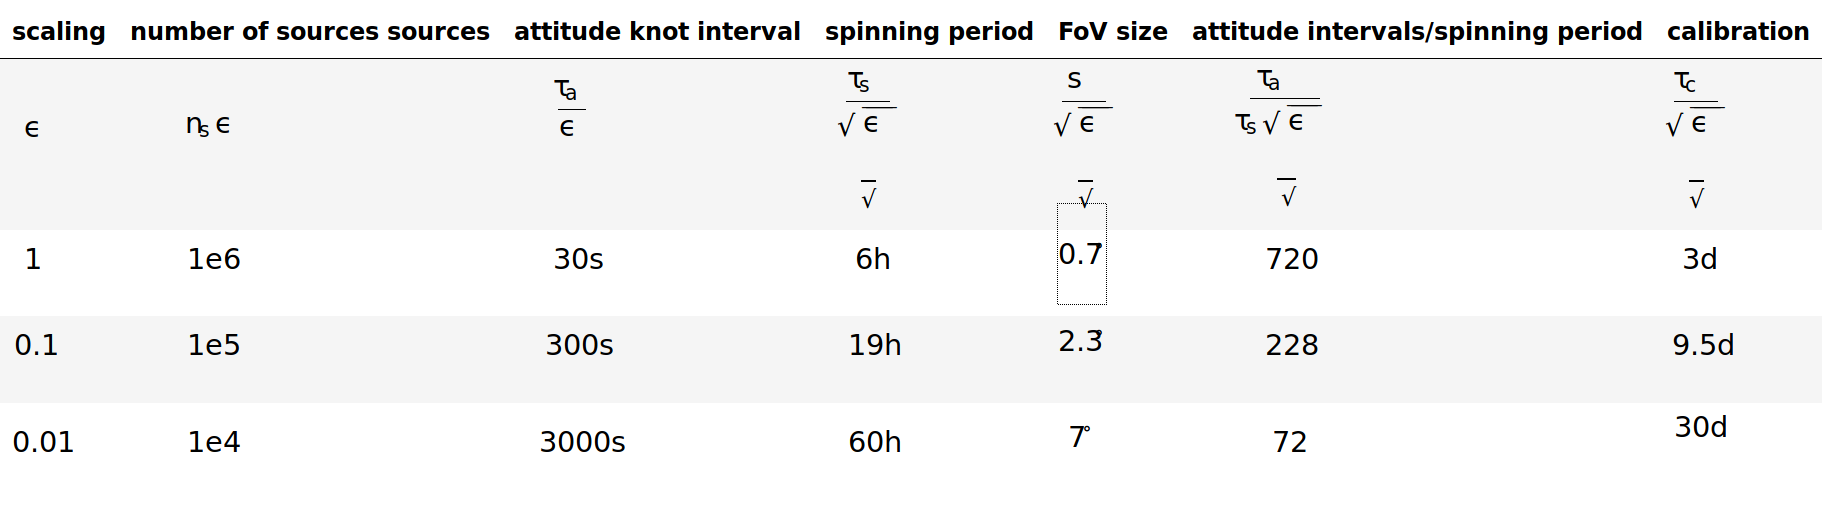

In [2]:
Image('./figures/scaling_factors.png')

In [3]:
# Thus:  (not in use for the moment)
"""Epsilon = 1

num_sources = num_sources*Epsilon
attitude_interval = attitude_interval / Epsilon
spinning_period = spinning_period / np.sqrt(Epsilon)
FoV_size = FoV_size / np.sqrt(Epsilon)"""
print(2)


2


# **Initializing objects:**

In [4]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  t_init + 1/2
my_dt = 1/24/2 # [days]

# objects
spline_degree = 3

gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_degree)
print('Sat created')

Sat created


In [5]:
double_telescope = True
my_scanner = Scanner(zeta_limit=np.radians(0.5) ,double_telescope=double_telescope) 
print('Scanner created')

num_sources=90  # has to be divisible by 3

Scanner created


# End scanner

In [6]:
times_for_source = np.linspace(t_init, t_end, num=num_sources//3, endpoint=True)  # ordered sources
# times_for_source = np.random.rand(num_sources//3)*(t_end-t_init)+t_init  # unordered sources

In [7]:
def generate_angles_of_sources(num_sources):
    """returns a number *num_sources* of ICRS coordinates (right ascension, declination)"""
    # Warning be carefull to what you use to get alpha/delta from vector
    # times_for_source = np.linspace(t_init, t_end, num=num_sources, endpoint=True)
    alphas, deltas = ([], [])
    for t in times_for_source:
        noise = np.random.rand(6) * 1e-6
        attitude = gaia.func_attitude(t)
        alpha, delta = generate_observation_wrt_attitude(attitude)
        a_P, d_P, a_F, d_F = get_angular_FFoV_PFoV(gaia, t)
        alphas += [alpha + noise[0]]
        deltas += [delta + noise[3]]
        alphas += [ a_P + noise[1], a_F + noise[2]]
        deltas += [ d_P + noise[4], d_F + noise[5]]
    return alphas, deltas

In [8]:
alphas, deltas = generate_angles_of_sources(num_sources)

In [9]:
# create soures from that: 
sources = []
for n in range(num_sources):
    sources.append(Source(str(n), np.degrees(alphas[n]), np.degrees(deltas[n]), 0, 0, 0, 0))
    # sources.append(Source(str(n), alphas[n], deltas[n], parallaxes[n], mu_alphas[n], mu_deltas[n], mu_radials[n]))
print('Sources created')

Sources created


# 1- Scan and results

### 1.1 Scan

In [10]:
obs_times = []
calc_sources = []
real_sources = []

for i in trange(len(sources)):
    s = sources[i]
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    """print('zetas:', my_scanner.zeta_scanned)
    print('etas:', my_scanner.eta_scanned)
    print('times:', my_scanner.obs_times)
    print('How many observation time?  {}'.format(len(my_scanner.obs_times)))"""
    if len(my_scanner.obs_times)>0:
        obs_times += my_scanner.obs_times
        """print('Error: ', my_scanner.scanner_error())"""
        real_sources.append(s)
        calc_sources.append(Calc_source(obs_times=my_scanner.obs_times.copy(), source=s))
sources = real_sources
obs_times = list(np.sort(obs_times))

100%|██████████| 90/90 [00:00<00:00, 125.94it/s]


In [11]:
if list(np.array(obs_times)[np.where(np.array(obs_times)>t_end)]):
    raise ValueError('observed time greater than end time')

### 1.2 Visualise results of scan

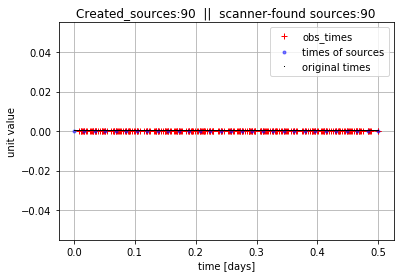

In [12]:
# Plot the distribution of sources and observation along the time axis
plt.figure()
plt.title('Created_sources:'+str(num_sources)+'  ||  scanner-found sources:'+str(len(calc_sources)))
plt.plot(obs_times,np.zeros(len(obs_times)), 'r+', label='obs_times')
plt.plot(times_for_source, np.zeros(len(times_for_source)), 'b.', label='times of sources', alpha=0.5)
sampled_times = np.linspace(t_init, t_end, num=500)
plt.plot(sampled_times, np.zeros(len(sampled_times)), 'k,', label='original times')
plt.xlabel('time [days]'), plt.ylabel('unit value') # , plt.ylim((-1e-6, 1e-6))

plt.grid(), plt.legend(), plt.show();

#bins: 23


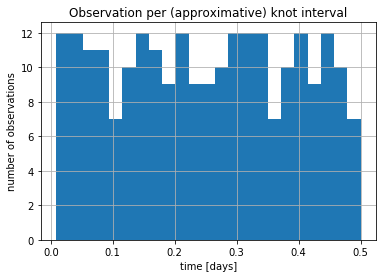

In [13]:
# plot the distibution of observations as a histogram with bin-size approximatively equal 
# to the one the attitude knot interval
plt.figure()
plt.title('Observation per (approximative) knot interval')
knots = gaia.s_x.get_knots()
bins = int(len(knots))
print('#bins:', bins)
plt.hist(obs_times, bins=bins, align='mid');
plt.xlabel('time [days]'), plt.ylabel('number of observations')
plt.grid(), plt.show();


# **2.- Test Solver source update:**
Note that for the source update to work properly there should be a minimum number of observations per source (10 is sufficient)

In [14]:
def noise_calc_sources(s):
    noise = 0.02 / 1000
    s.s_params[0] += noise
    s.s_params[1] += noise
    s.s_params[2] += -s.s_params[2]/100
    s.s_params[3] += s.s_params[3]*0.01
    s.s_params[4] += s.s_params[4]*0.01

In [15]:
tmp_calc_sources = copy.deepcopy(calc_sources)

In [16]:
for s in tmp_calc_sources:
    noise_calc_sources(s)

In [17]:
print('Updating only sources')
Solver = Agis(gaia, tmp_calc_sources, sources, updating='scanned source', double_telescope=double_telescope)

Updating only sources


In [18]:
Solver.error_function()

3.125176069055827e-10

In [19]:
# Uncomment to run the update (might be slow!)
# Solver.reset_iterations()
# Solver.iterate(10)

# 3.- *Update Attitude*

In [20]:
if len(sources) != len(calc_sources):
    raise ValueError('there must be the same number of real and calc sources')

### 3.1 Create Solver

In [21]:
spline_degree = 3
Solver = Agis(sat=gaia, calc_sources=calc_sources, real_sources=sources, updating='attitude',
              double_telescope=double_telescope,
              attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], 
              spline_degree=spline_degree,
              attitude_regularisation_factor=1e-2)

In [22]:
# Ignore this cell if you don't want to modify the initial attitude
# Can be used to check that when recreating the splines in the solver we (almost) do not create additional errors
my_times = np.array(obs_times)
# Solver.actualise_splines()
print('Error before Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-6
print('c_noise shape: ', c_noise.shape)
last_coef = 4
#Solver.att_coeffs[:last_coef] = Solver.att_coeffs[:last_coef] + c_noise[:last_coef]
Solver.actualise_splines()
#Solver.set_splines_basis()
print('Error after Noise: ', Solver.error_function())
# print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))

Error before Noise:  0.0
c_noise shape:  (4, 25)
Error after Noise:  0.0


### 3.2 Visualize Solver data

In [23]:
if (Solver.att_knots.shape[0] - Solver.att_coeffs.shape[1]) != 4:
    raise ValueError('there should be 4 coeffs less than the number of knots')

##### 3.2.1 Visualize attitude

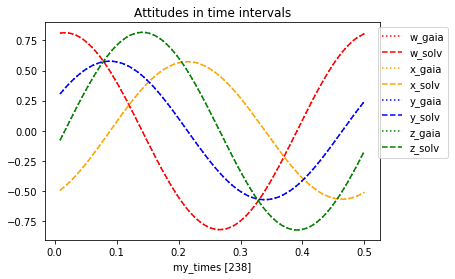

In [24]:
# compare initial difference between satellite and solver attitudes
compare_attitudes(gaia, Solver, obs_times)

##### 3.2.2 Visualize Matrices

In [25]:
# Compute Normal matrix
N_aa = Solver.compute_attitude_LHS()

N_aa_w = N_aa[0::4, 0::4]
N_aa_x = N_aa[1::4, 1::4]
N_aa_y = N_aa[2::4, 2::4]
N_aa_z = N_aa[3::4, 3::4]
N_aa_list = [N_aa_w, N_aa_x, N_aa_y, N_aa_z]

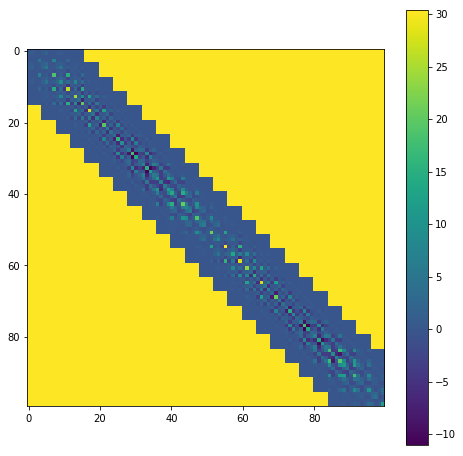

In [26]:
A=N_aa
plt.figure(figsize=(8,8))
threshold = 0
A[np.where(A==threshold)] = A.max()
plt.imshow(A, vmin=None, vmax=None)
plt.colorbar()
plt.show();

In [27]:
type_list = ['w', 'x', 'y', 'z']
# Plot the 4 submatrices
"""fig, axs = plt.subplots(4, 2, figsize=(24, 24))


for i in range(4):
    A = N_aa_list[i].copy()
    plot1 = axs[i, 0].imshow(np.abs(A), vmin=None, vmax=None)
    axs[i, 0].set_title("$|N_{aa}|$ type:"+type_list[i])
    
    threshold = 0
    A[np.where(A==threshold)] = A.max()
    plot2 = axs[i, 1].imshow(A, vmin=None, vmax=None)
    axs[i, 1].set_title("$N_{aa}$ , with zeros to max(A)"+type_list[i])

    fig.colorbar(plot1, ax=axs[i, 0])
    fig.colorbar(plot2, ax=axs[i, 1])
    
fig.suptitle('Matrix visualization')
plt.show();"""
print()

##### 3.2.3 Visualize eigen properties of Normal matrix

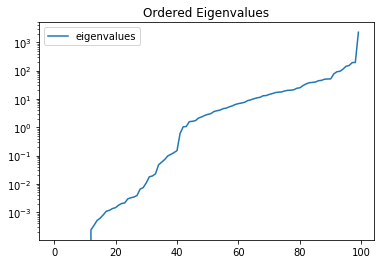

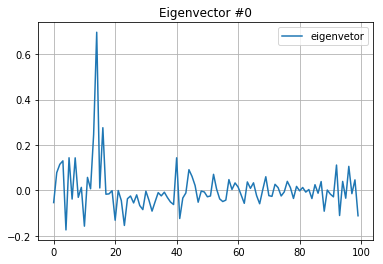

In [28]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
plt.figure()

plt.title('Ordered Eigenvalues')
plt.plot(eig_vals, label='eigenvalues')
    
plt.yscale('log'), plt.legend()
# plt.xlim(0,5)
plt.show();

index=0
plt.figure()
plt.title('Eigenvector #'+str(index))
plt.plot(eig_vecs[index], label='eigenvetor')
#plt.xlim(100,110)
plt.grid(), plt.legend(), plt.show();

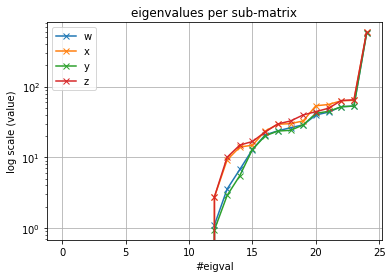

In [29]:
plt.figure()
for i, Naa in enumerate(N_aa_list):
    eig_vals, eig_vecs = np.linalg.eigh(Naa)
    plt.plot(eig_vals, label=type_list[i],marker='x')
    if not helpers.check_symmetry(Naa):
        raise ValueError('Matrix not symmetric')
    # print('Condition number: ', np.linalg.cond(Naa))
    # print('Condition number (eig_max/eig_min): ', np.abs(eig_vals.max())/np.abs(eig_vals.min()))
    # print('Rank: ', np.linalg.matrix_rank(Naa, hermitian=True))
    # print('det(N_aa):', np.linalg.det(Naa),'\n')
plt.yscale('log'), plt.legend(), plt.grid()
plt.title('eigenvalues per sub-matrix'), plt.ylabel('log scale (value)'), plt.xlabel('#eigval')
# plt.xlim((0,5))

plt.show()

### 3.3 **Iterate**

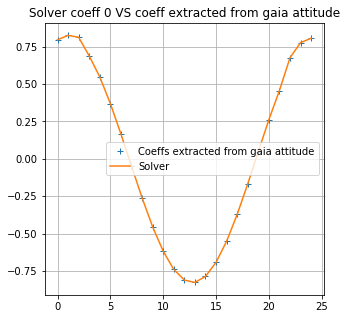

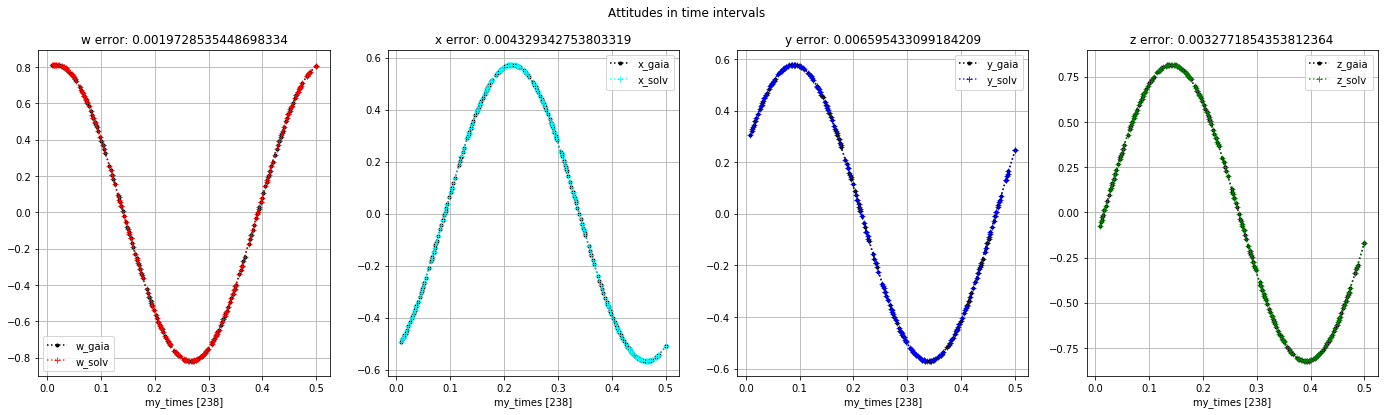

MAGNITUDE: 0.9999614543041065


In [30]:
Solver.verbose=False
# Solver.reset_iterations()
Solver.iterate(1)

plt.figure(figsize=(5,5))
c, t, s = extract_coeffs_knots_from_splines([gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], k=3)
plt.plot(c[0], '+', label='Coeffs extracted from gaia attitude')
plt.plot(Solver.att_coeffs[0], label='Solver')
plt.title('Solver coeff 0 VS coeff extracted from gaia attitude')
plt.grid(), plt.legend(), plt.show()
fig2 = multi_compare_attitudes(gaia, Solver, obs_times)
print('MAGNITUDE:', Solver.get_attitude(0.005, unit=False).magnitude)
fig2.savefig('figures/tmp/lala.png')

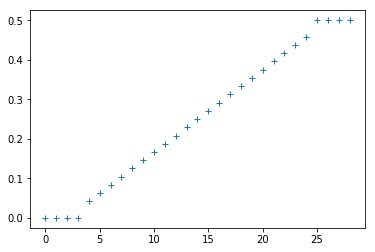

In [31]:
plt.plot(Solver.att_knots, '+')
plt.show()

In [32]:
Solver.iterate(2)

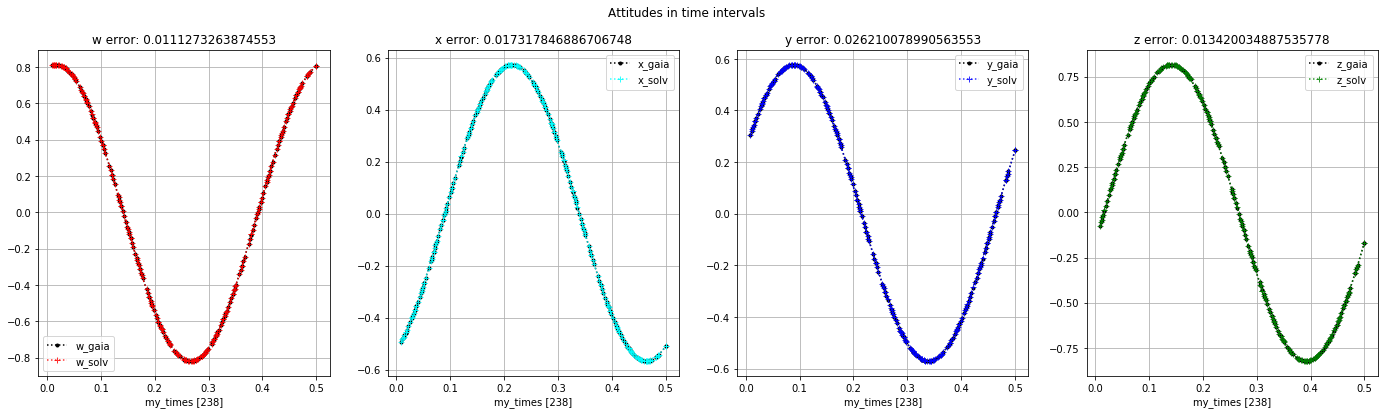

In [33]:
fig2 = multi_compare_attitudes(gaia, Solver, obs_times)


# 4.- Tests

### 4.1 Test sparese implementation:

In [34]:
# ~ what is done when we set use_sparse=True in method Solver.iterate
der_band, reg_band = Solver.compute_attitude_banded_derivative_and_regularisation_matrices()
Solver.compute_sparses_matrices(der_band, reg_band)
LHS_sps = Solver.attitude_der_matrix + Solver.attitude_reg_matrix
RHS = Solver.compute_attitude_RHS()
d_sps = sps.linalg.spsolve(LHS_sps, RHS)

In [35]:
# ~ Full matrix version of iterate
LHS_full = Solver.compute_attitude_LHS()
RHS = Solver.compute_attitude_RHS()
d_full = np.linalg.solve(LHS_full, RHS)

##### 4.1.1 Test
They seem close but not really almost equals?

In [36]:
np.testing.assert_array_almost_equal(LHS_sps.toarray(), LHS_full, decimal=3)

np.testing.assert_array_almost_equal(d_sps.flatten(), d_full.flatten(), decimal=3)